# Patch weighting

### Load image and corresponding density map

In [1]:
from PIL import Image, ImageDraw, ImageFont
import os, torch
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

/home/matteopierucci/anaconda3/envs/clipcount/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SCALE_FACTOR = 60.0

image_directory = "../data/FSC/images_384_VarV2"
density_directory = "../data/FSC/gt_density_map_adaptive_384_VarV2"
filename = "6600"

image_filename = os.path.join(image_directory, filename + ".jpg")
denisty_filename = os.path.join(density_directory, filename + ".npy")

image = Image.open(image_filename)
density_map = np.load(denisty_filename)

In [3]:
density_map_tensor = torch.tensor(density_map)
density_map_tensor.shape

print(torch.sum(density_map_tensor).item())
print(density_map_tensor.shape)

11.999999046325684
torch.Size([384, 408])


In [4]:
split_tensors_axis0 = torch.chunk(density_map_tensor, 14, dim=0)
print(split_tensors_axis0[1].shape)
split_tensors = [torch.chunk(chunk, 14, dim=1) for chunk in split_tensors_axis0]

sum = 0
patches_counts = []

for i in range(14):
    for j in range (14):
        objects_per_patch = torch.sum(split_tensors[i][j]).item()
        print(round(objects_per_patch, 1), end=" | ")
        patches_counts.append(objects_per_patch)
        sum += objects_per_patch
    print()
        
print("final_sum: ", sum)

torch.Size([28, 408])
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.5 | 1.2 | 1.2 | 1.2 | 1.0 | 1.1 | 1.3 | 1.2 | 1.1 | 1.3 | 1.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 
0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0

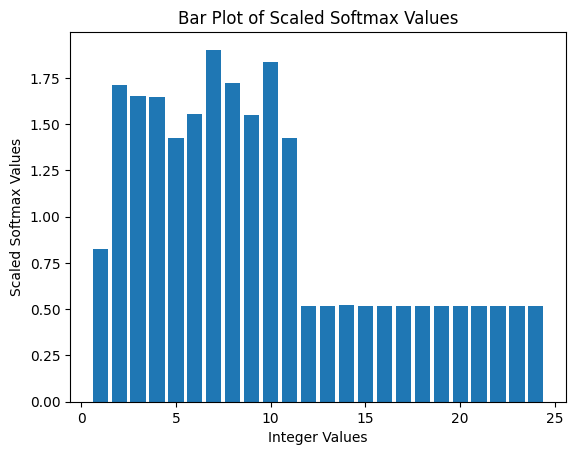

Sum of all elements inside scaled_softmax: 24.000001907348633


In [5]:
tensor_counts = torch.tensor(patches_counts)
non_zero_tensor = tensor_counts[tensor_counts != 0]
softmax_output = F.softmax(non_zero_tensor, dim=0)
non_zero_count = torch.count_nonzero(tensor_counts)
scaled_softmax = softmax_output * non_zero_tensor.numel()

# Extract data for plotting
x_values = torch.arange(1, len(scaled_softmax) + 1)  # Assuming 1-indexed
y_values = scaled_softmax.numpy()

# Create bar plot
plt.bar(x_values, y_values)

# Labeling axes
plt.xlabel('Integer Values')
plt.ylabel('Scaled Softmax Values')

# Title for the plot
plt.title('Bar Plot of Scaled Softmax Values')

# Display the plot
plt.show()

sum_scaled_softmax = scaled_softmax.sum().item()
print("Sum of all elements inside scaled_softmax:", sum_scaled_softmax)

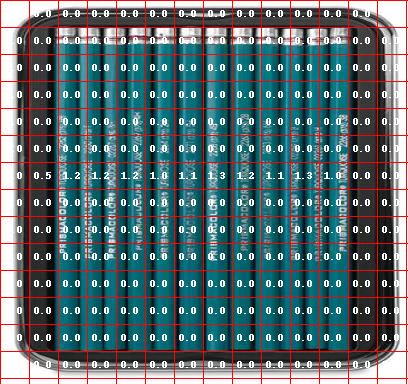

In [6]:
grid_size = 14
image_width, image_height = image.size
cell_width = image_width // grid_size
cell_height = image_height // grid_size

draw = ImageDraw.Draw(image)

for x in range(0, image_width, cell_width):
    line = ((x, 0), (x, image_height))
    draw.line(line, fill="red")


for y in range(0, image_height, cell_height):
    line = ((0, y), (image_width, y))
    draw.line(line, fill="red")



for y in range(0, image_height, cell_height):
    if y//cell_height == 14:
            break
    i = 0 if y == 0 else y//cell_height
    for x in range(0, image_width, cell_width):
        if x//cell_width == 14:
            break
        j = 0 if x == 0 else x//cell_width
        text = str(round(torch.sum(split_tensors[i][j]).item(), 1))
        text_width, text_height = draw.textsize(text)
        text_x = x + (cell_width - text_width) // 2
        text_y = y + (cell_height - text_height) // 2
        draw.text((text_x, text_y), text, fill="white")

image.show()